<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/Barrages/PowerLimits_2025_V04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as mpl
import os, pathlib
import scipy.integrate as integrate
from IPython.display import display, Markdown

import pathlib, os, sys

try:
    from dataclassy import dataclass
except ModuleNotFoundError:
    os.system( "pip install dataclassy" )
    from dataclassy import dataclass

if not pathlib.Path("mpl_utils.py").exists():
    os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

To print the notebook use (win/linux/mac):

```jupyter nbconvert PowerLimits_2025_V04.ipynb --to webpdf```

in the command line.

In [20]:
π = np.pi
two_π = 2.0 * π
ρ = 1000.0
gr = 9.8

## Basin modelling

Let us assume a rectangular basin

<img src="https://raw.githubusercontent.com/joaochenriques/IST_MCTE/main/Barrages/Figures/BasinShoeBox_MWL.svg" width="400px" style="display:inline">




The opening and closing turbine instants are $t_1$ and $t_2$



<img src="https://raw.githubusercontent.com/joaochenriques/IST_MCTE/main/Barrages/Figures/MaxPower_Z.svg" width="500px" style="display:inline">

Since the basin is assumed to drain linearly, flow rate per unit of basin area  is

$$\frac{Q}{S}=-\frac{z_2-z_1}{t_2-t_1}$$



In [21]:
T = 12.46*3600  # hours
H = 10.0         # meter
EoS_max = 0.5 * ρ * gr * H**2

ω = two_π / T
A  = H / 2.0
t1 = 0.3 * T
t2 = 0.7 * T

z1 = A
z2 = A * np.cos( ω * t2 )

# The suffix "oS" means "over S
QoS = -( z2 - z1 ) / ( t2 - t1 )

display( Markdown( rf'$Q/S = {QoS:.4g}$' ) )

$Q/S = 0.0003648$

The stored energy in the basin per unit of basin area is

$$\frac{E_\mathrm{max}}{S}=\frac 12 \rho g H^2$$

Since the available power is

$$\frac{1}{S}\frac{d E_\mathrm{avail}}{d t} = \frac{P_\mathrm{avail}}{S} = \rho g h(t) \frac{Q}{S}$$


and the extracted energy is


$$\frac{E_\mathrm{avail}}{S} = \frac{1}{S} \int_{t_1}^{t_2} P_\mathrm{avail} \, d t$$

We can define a dimensionless measure of the extracted energy from $t_1$ up to $t$ as

$$E_\mathrm{avail}^*(t) = \frac{\ \displaystyle \frac{E_\mathrm{avail}(t)}{S}\ }{\displaystyle \frac{E_\mathrm{max}}{S}}$$


The overall efficiency of the emptying process is given by

$$\eta_\mathrm{empt} = \frac{\ \displaystyle \frac{E_\mathrm{avail}(t_2)}{S}\ }{\displaystyle \frac{E_\mathrm{max}}{S}}$$


The maximum capacity factor can be estimated from


$$\mathrm{CF}_{\mathrm{max}} = \frac{\displaystyle \frac{1}{T}\frac{E_\mathrm{avail}(t_2)}{S}\ }{\displaystyle \mathrm{max}\!\left(\frac{ P_\mathrm{avail}(t)}{S}\right)}$$


The mean $\langle\sqrt{{gh}}\rangle$ is given by

$$\langle\sqrt{{gh}}\rangle = \frac{1}{t_2-t_1} \int_{t_1}^{t_2} \sqrt{ g \left( z(t)-A\cos\left(\frac{2\pi t}{T}\right)\right)} \, dt$$


In [27]:
S = 2.33E+07
QoS * S

8499.447111015332

In [35]:
@dataclass
class TurbineModel:

  # flow rate: red line of the map
  poly_CQ1: np.poly1d = np.poly1d( np.array([0.16928201, 0.08989368]) )

  # flow rate: green line of the map
  poly_CQ2: np.poly1d = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03,
                                         -9.25873626e-02,  1.75687197e+00]) )

  # efficiency: red line of the map
  poly_CE1: np.poly1d = np.poly1d( np.array([-0.02076456, 0.20238444,
                                              0.48984553]) )
  # efficiency: green line of the map
  poly_CE2: np.poly1d = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,
                                             6.86081825e-04,  7.93083108e-01]) )

  η_max: float = 0.912  # [-] maximum efficiency

  # n11 interpolation domain
  n11_min: float =  4.38    # [-]
  n11_max: float = 17.17    # [-]
  n11_r2g: float =  7.92193 # [-] red to green point

  # other data
  ga: float = 9.8         # [m/s²] gravity aceleration
  ρw: float = 1025.0      # kg/m³] water density

  def n11_range( self ) -> tuple:
    return ( self.n11_min, self.n11_max )

  # dimensionless flow rate
  def Q11( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < self.n11_r2g:
      return self.poly_CQ1( n11 )
    else:
      return self.poly_CQ2( n11 )

  # efficiency
  def eta( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < self.n11_r2g:
      return self.poly_CE1( n11 ) * self.η_max
    else:
      return self.poly_CE2( n11 ) * self.η_max

In [36]:
TM = TurbineModel()
n11_min, n11_max = TM.n11_range()

In [37]:
eps = 1E-8
nn = 1000

t_vec = np.linspace( t1, t2-eps, nn )
Δt = t_vec[1] - t_vec[0]

z_vec   = np.zeros( nn ) # instantaneous z
h_vec   = np.zeros( nn ) # instantaneous h
EoS_vec = np.zeros( nn ) # accumulated energy since t1

In [42]:
mean_h = 0
mean_h_1o4 = 0
mean_h_1o2 = 0
mean_h_3o4 = 0

PoS_max = 0

z_vec[0] = A
h_vec[0] = A - A * np.cos( ω * t1 )

for i in range( 1, nn ):
    z_vec[i] = z_vec[i-1] - Δt * QoS

    h_vec[i] = z_vec[i] - A * np.cos( ω * t_vec[i] )

    PoS = ρ * gr * h_vec[i] * QoS
    PoS_max = np.max( ( PoS_max, PoS ) )

    EoS_vec[i] = EoS_vec[i-1] + Δt * PoS

    mean_h += h_vec[i] * Δt
    mean_h_1o4 += h_vec[i]**0.25 * Δt
    mean_h_1o2 += h_vec[i]**0.50 * Δt
    mean_h_3o4 += h_vec[i]**0.75 * Δt

mean_h /= ( t2 - t1 )
mean_h_1o4 /= ( t2 - t1 )
mean_h_1o2 /= ( t2 - t1 )
mean_h_3o4 /= ( t2 - t1 )

Eff = EoS_vec[-1] / EoS_max
CF = ( EoS_vec[-1] / T )  / PoS_max

display( Markdown( rf'$E_\mathrm{{avail}}/S = {EoS_vec[-1]:.1f}$' ) )
display( Markdown( rf'$E_\mathrm{{avail}}^\mathrm{{max}}/S = {EoS_max:.1f}$' ) )
display( Markdown( rf'$\eta_\mathrm{{empt}} = {Eff:.3f}$' ) )
display( Markdown( rf'$\mathrm{{CF}}_{{\mathrm{{max}}}} = {CF:.3f}$' ) )
display( Markdown( rf'$\langle h \rangle = {mean_h:.3f}$' ) )
print()
display( Markdown( rf'$\langle h^{{1/4}}\rangle = {mean_h_1o4:.3f}$' ) )
display( Markdown( rf'$\langle h^{{1/2}}\rangle = {mean_h_1o2:.3f}$' ) )
display( Markdown( rf'$\langle h^{{3/4}}\rangle = {mean_h_3o4:.3f}$' ) )
print()
display( Markdown( rf'$\langle h \rangle^{{1/4}} = {mean_h**0.25:.3f}$' ) )
display( Markdown( rf'$\langle h \rangle^{{1/2}} = {mean_h**0.50:.3f}$' ) )
display( Markdown( rf'$\langle h \rangle^{{3/4}} = {mean_h**0.75:.3f}$' ) )

$E_\mathrm{avail}/S = 353313.3$

$E_\mathrm{avail}^\mathrm{max}/S = 490000.0$

$\eta_\mathrm{empt} = 0.721$

$\mathrm{CF}_{\mathrm{max}} = 0.297$

$\langle h \rangle = 5.508$

$\langle h^{1/4}\rangle = 1.490$

$\langle h^{1/2}\rangle = 2.273$

$\langle h^{3/4}\rangle = 3.520$

$\langle h \rangle^{1/4} = 1.532$

$\langle h \rangle^{1/2} = 2.347$

$\langle h \rangle^{3/4} = 3.596$

In [44]:
h_max = np.max( h_vec )

mean_n11 = 0
mean_Q11 = 0

ND = np.sqrt( 9.8 * h_max ) * n11_min
i = 0

for i in range( 1, nn ):
    n11 = ND / np.sqrt( 9.8*h_vec[i] )

    if n11 > n11_max:
        break
    Q11 = TM.Q11( n11 )

    mean_n11 += n11
    mean_Q11 += Q11

mean_n11 /= i
mean_Q11 /= i

mean_n11, mean_Q11

(5.559683875931334, 0.974675060139944)

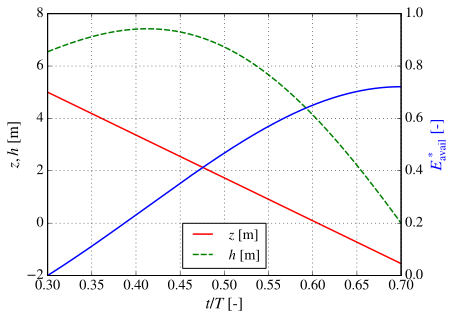

In [24]:
fig, ax1 = mpl.subplots()

ax2 = ax1.twinx()
ax1.plot( t_vec / T, z_vec, 'r', label=r'$z$ [m]' )
ax1.plot( t_vec / T, h_vec, 'g', label=r'$h$ [m]' )
ax2.plot( t_vec / T, EoS_vec / EoS_max, 'b' )

ax1.set_xlabel('$t/T$ [-]')
ax1.set_ylabel('$z,h$ [m]')
ax1.grid()
ax1.legend(loc='lower center')
ax2.set_ylim( 0, 1 )
ax2.set_ylabel('$E_\mathrm{avail}^*$ [-]', color='b');